# **KLASIFIKASI SINYAL TRADING PADA SAHAM ASUS**
Machine Learning (IF540-EL) - Kelompok 2

---

# **📚 LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import talib
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.calibration import label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score


---

# **🔍 DATA UNDERSTANDING**

In [2]:
df = pd.read_csv("Datasets/ASUS.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-13,272.5,277.5,272.5,276.5,185.351166,1137998
1,2018-03-14,274.5,276.0,274.0,274.0,183.675293,487354
2,2018-03-15,274.0,277.5,274.0,275.0,184.345627,779897
3,2018-03-16,277.5,279.0,275.0,276.0,185.015991,2009095
4,2018-03-19,276.0,278.0,275.0,277.5,186.021515,394556


In [3]:
df.shape    

(1216, 7)

In [4]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.max()

Date         2023-03-10
Open              413.0
High              428.0
Low               395.0
Close             409.5
Adj Close    330.402832
Volume         24595161
dtype: object

---

# **🧹 DATA PREPROCESSING**

## Features Engineering

Penambahan fitur-fitur berupa indikator teknikal yang umum dipakai oleh trader saham meliputi diantaranya relative strength index (RSI), Stochastic Oscillator (STOCH), Williams %R, Rate of Change Price (ROCP / PROC), serta Moving Average Convergence/Divergence (MACD).

In [6]:
# Calculate RSI
df['RSI'] = talib.RSI(df['Close'])

# Calculate Stochastic Oscillator
slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=3, slowd_period=3)
df['SlowK'] = slowk
df['SlowD'] = slowd

# Calculate Williams %R
df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

# Calculate Price Rate of Change
df['PROC'] = talib.ROCP(df['Close'], timeperiod=10)

# Calculate MACD
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACDSignal'] = macdsignal
df['MACDHist'] = macdhist

## Labelling Data

Proses labelling data dengan memperhitungkan perbedaan harga saham dengan hari sebelumnya. Setelah perbedaan diketahui maka asumsi yang digunakan adalah jika harga <0 sinyal jual (-1), tidak ada perubahan sinyal hold (0), dan jika >0 maka sinyal beli (1)

In [7]:
df['Diff'] = df['Close'].diff()
df['Signal'] = df['Close'].transform(lambda x : np.sign(x.diff()))

df.dropna(inplace=True)



df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,SlowK,SlowD,WILLR,PROC,MACD,MACDSignal,MACDHist,Diff,Signal
33,2018-05-03,276.0,280.5,275.5,280.0,187.697388,1511968,54.300423,70.000000,67.222222,-20.000000,0.010830,1.273218,1.332229,-0.059011,1.0,1.0
34,2018-05-04,276.0,278.5,276.0,276.0,185.015991,950166,46.544915,64.814815,66.604938,-55.555556,-0.012522,0.971369,1.260057,-0.288688,-4.0,-1.0
35,2018-05-07,279.0,279.0,274.5,275.0,184.345627,712172,44.821392,52.592593,62.469136,-66.666667,-0.014337,0.644035,1.136853,-0.492817,-1.0,-1.0
36,2018-05-08,278.5,280.5,277.0,280.0,187.697388,1652685,53.994372,55.092593,57.500000,-12.500000,0.012658,0.779098,1.065302,-0.286204,5.0,1.0
37,2018-05-09,278.0,279.0,276.0,276.5,185.351166,950413,47.981325,54.861111,54.182099,-56.250000,-0.008961,0.596836,0.971609,-0.374773,-3.5,-1.0


Visualisasi Grafik harga saham berdasarkan sinyal yang dihasilkan pada tahap labelisasi diatas

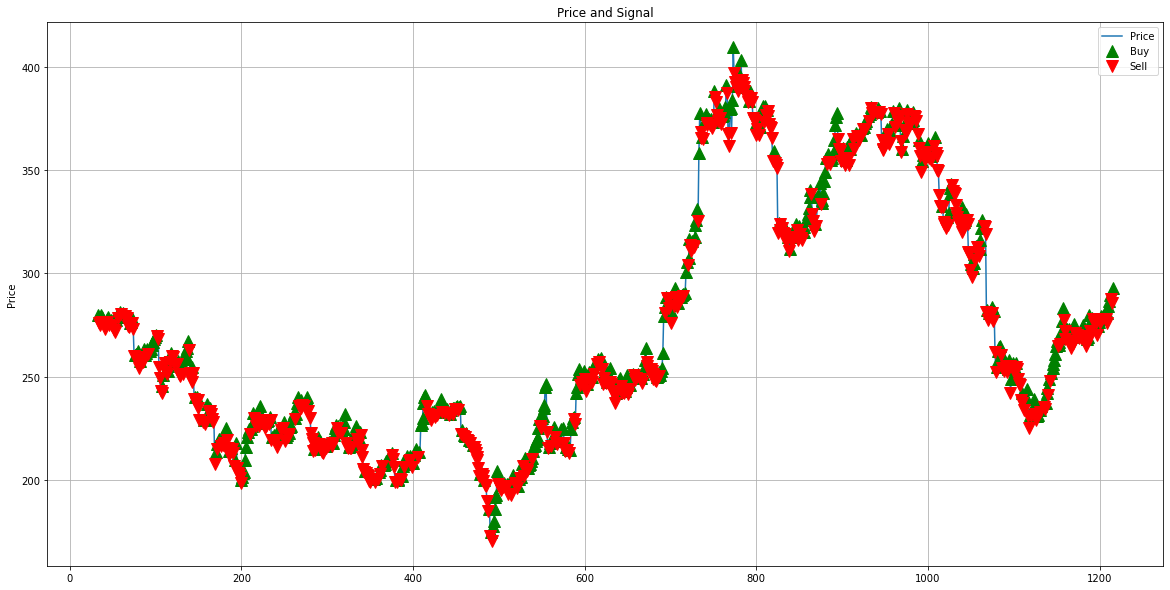

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df.index, df['Close'], label='Price')

# Plot the buy and sell signals on the Adj Close price figure
ax.plot(df[df['Signal'] == 1].index, df['Close'][df['Signal'] == 1],
        '^', markersize=12, color='g', label='Buy')
ax.plot(df[df['Signal'] == -1].index, df['Close'][df['Signal'] == -1],
        'v', markersize=12, color='r', label='Sell')

# Set axis labels and title
ax.set_ylabel('Price')
ax.set_title('Price and Signal')

# Add legend and grid
ax.legend()
ax.grid()

plt.show()


## Data Splitting

Object untuk menyimpan data splitting untuk nanti digunakan pada tahap modelling.

In [9]:
datasets = { }

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

### Pemisahan Independent dan Dependent Variable

Independent variable atau features yang kami gunakan sepenuhnya merupakan indikator teknikal pada trading saham yang dihasilkan pada proses feature engineering sebelumnya, dengan target atau dependent variable adalah signal hasil labelisasi.

In [11]:
cols = ['RSI','SlowK','SlowD','WILLR','PROC','MACD']

X = df[cols]
y = df[['Signal']].values.reshape(-1, 1).ravel()

### Pemisahan Data Training dan Testing

Pemisahan dilakukan dengan ukuran 80:20 dan stratified dengan nilai y, hal ini dilakukan agar proporsi penyebaran data merata.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=24, 
    stratify=y)



datasets['multiclass'] = (X_train, X_test, y_train, y_test)

## SMOTE Oversampling Data

Memahami bahwa data bersifat imbalanced, maka dari itu kami melakukan SMOTE Oversampling agar data yang dihasilkan memiliki ratio data training yang sama.

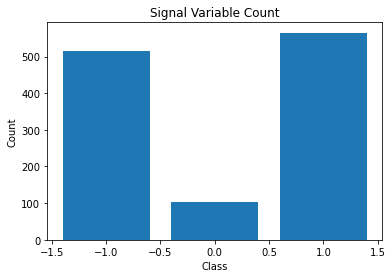

In [13]:
def visualize_count(df):
    # Count the number of instances for each class
    class_counts = df['Signal'].value_counts()

    # Plot the counts using a bar plot
    plt.bar(class_counts.index, class_counts.values)
    plt.title('Signal Variable Count')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

visualize_count(df)

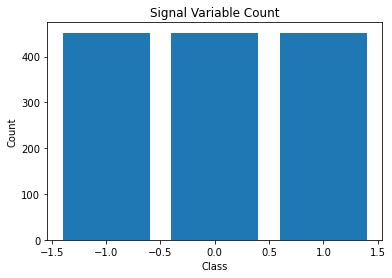

In [14]:
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

df_resampled = pd.concat([pd.DataFrame(X_train_resampled), pd.DataFrame(y_train_resampled, columns=['Signal'])], axis=1)
df_resampled.dropna(inplace=True)
df_resampled.head(5)
visualize_count(df_resampled)

In [15]:
datasets['multiclass_oversampled'] = (X_train_resampled, X_test, y_train_resampled, y_test)

## Data Tanpa Class 0 atau Sinyal Hold

Selanjutnya pemisahan data tanpa class 0 dilakukan untuk menguji performa data tanpa sinyal hold, hal ini dilakukan karena akurasi macro pada class 0 yang sangatlah rendah.

In [16]:
df_binary = df[df['Signal'] != 0]

In [17]:
X_binary, y_binary = df_binary[cols], df_binary['Signal'].values.ravel()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.25, stratify=y_binary)

In [19]:
datasets['binary_class'] = (X_train, X_test, y_train, y_test)

---

## **🖧 MODELLING**

### Deklarasi Fungsi

Fungsi roc_curve_plot menerima input berupa model random forest serta object data untuk nantinya membuat visualisasi ROC Curve berdasarkan dengan jumlah class.

In [20]:
def roc_curve_plot(rf_model, data):

    (X_train, X_test, y_train, y_test) = data
    unique_labels = np.unique(np.concatenate((y_train, y_test)))

    if len(unique_labels) == 2:
        # Binary classification: Convert labels to binary format
        y_test_bin = label_binarize(y_test, classes=unique_labels)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability predictions for positive class
        fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
        auc_score = roc_auc_score(y_test_bin, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    else:
        # Multiclass classification: Calculate macro-average ROC curve and AUC score
        y_test_bin = label_binarize(y_test, classes=unique_labels)
        y_pred_proba = rf_model.predict_proba(X_test)

        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(unique_labels)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average ROC curve and AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(unique_labels))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(unique_labels)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(unique_labels)
        roc_auc["macro"] = auc(all_fpr, mean_tpr)

        # Plot macro-average ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(all_fpr, mean_tpr, label='Macro-average ROC Curve (AUC = {:.2f})'.format(roc_auc["macro"]))
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

Fungsi best_random_forest_model() menerima input berupa data, serta param_grid. Fungsi ini mengimplementasi GridSearchCV dalam rangka mengoptimalisasi pencarian model dengan akurasi terbaik, serta menampilkan seluruh hasil.

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider when looking for the best split
}


def best_random_forest_model(data, param_grid = param_grid):
    X_train, X_test, y_train, y_test = data

    rf_classifier = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    
    #Train and Test Accuracy
    y_pred_train = grid_search.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print("Training accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)


    #Print Classification Report
    print(classification_report(y_test, y_pred, zero_division=False))

    # Create a heatmap plot
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
    print('Cross-validation scores:', cv_scores)
    print('Average cross-validation score:', cv_scores.mean())

    # Check for overfitting
    if test_accuracy > cv_scores.mean():
        print('The model may be overfitting to the training data')
    else:
        print('The model is not overfitting to the training data')

    return grid_search.best_estimator_

    

### Pembuatan Model pada Data Sebelum Oversammpling

Best parameters found:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.8890063424947146
Test accuracy: 0.7215189873417721
              precision    recall  f1-score   support

        -1.0       0.72      0.81      0.76       103
         0.0       0.00      0.00      0.00        21
         1.0       0.72      0.78      0.75       113

    accuracy                           0.72       237
   macro avg       0.48      0.53      0.50       237
weighted avg       0.66      0.72      0.69       237



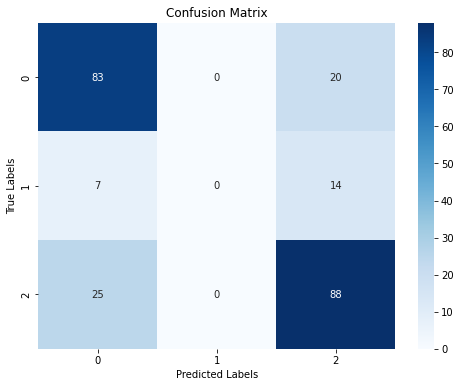

Cross-validation scores: [0.72631579 0.70899471 0.72486772 0.75661376 0.7989418 ]
Average cross-validation score: 0.7431467557783347
The model is not overfitting to the training data


In [22]:
rf = best_random_forest_model(datasets['multiclass'])

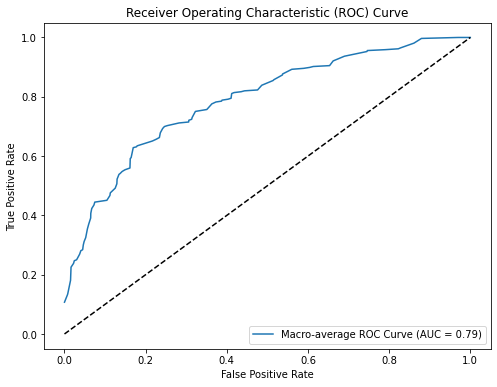

In [23]:
roc_curve_plot(rf, datasets['multiclass'])

### Pembuatan Model Pada Data Setelah Oversampling

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training accuracy: 1.0
Test accuracy: 0.6582278481012658
              precision    recall  f1-score   support

        -1.0       0.72      0.73      0.72       103
         0.0       0.16      0.24      0.19        21
         1.0       0.75      0.67      0.71       113

    accuracy                           0.66       237
   macro avg       0.54      0.55      0.54       237
weighted avg       0.68      0.66      0.67       237



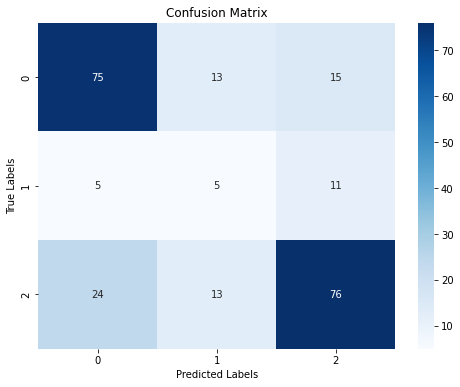

Cross-validation scores: [0.73161765 0.78228782 0.77859779 0.80811808 0.80811808]
Average cross-validation score: 0.7817478836553071
The model is not overfitting to the training data


In [24]:
rf_oversampled = best_random_forest_model(datasets['multiclass_oversampled'])

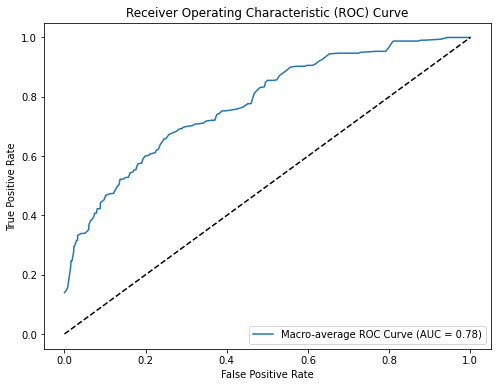

In [25]:
roc_curve_plot(rf_oversampled, datasets['multiclass_oversampled'])

### Pembuatan Model Tanpa Class 0 atau sinyal hold

Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training accuracy: 0.9864197530864197
Test accuracy: 0.8228782287822878
              precision    recall  f1-score   support

        -1.0       0.81      0.81      0.81       129
         1.0       0.83      0.83      0.83       142

    accuracy                           0.82       271
   macro avg       0.82      0.82      0.82       271
weighted avg       0.82      0.82      0.82       271



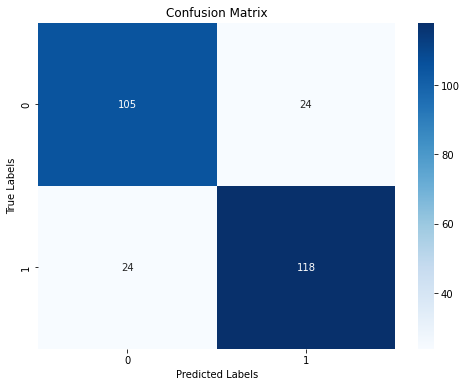

Cross-validation scores: [0.83333333 0.75308642 0.79012346 0.78395062 0.82716049]
Average cross-validation score: 0.7975308641975308
The model may be overfitting to the training data


In [27]:
rf_binary = best_random_forest_model(datasets['binary_class'])

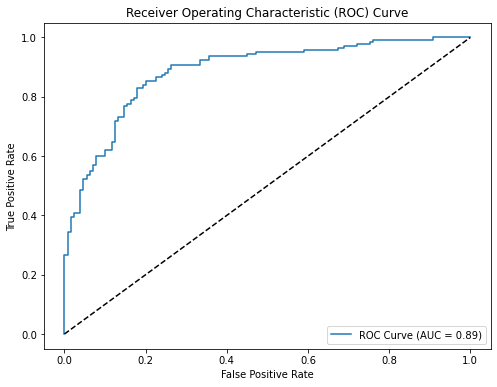

In [28]:
roc_curve_plot(rf_binary, datasets['binary_class'])

### Feature Importances

Memahami bahwasannya model dengan dua class atau tanpa sinyal hold maka perhitungan feature importances dilakukan dalam rangka memahami fitur apa-apa saja yang mempengaruhi dalam pembuatan model.

In [29]:
feature_imp = pd.Series(rf_binary.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

WILLR    0.322247
SlowD    0.164060
RSI      0.156355
SlowK    0.153874
PROC     0.105756
MACD     0.097707
dtype: float64

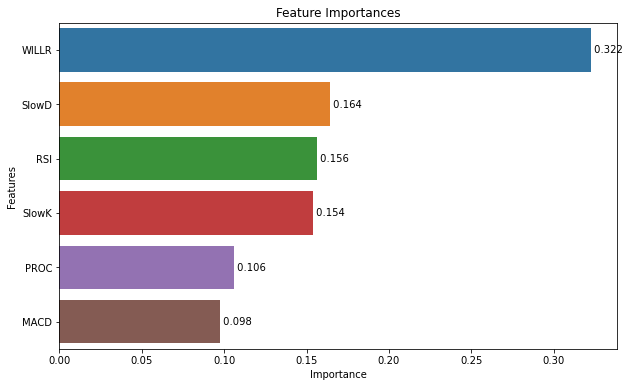

In [30]:
feature_imp = pd.Series(rf_binary.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_imp)

plt.figure(figsize=(10, 6))

# Create a bar plot using Seaborn
sns.barplot(x=feature_imp.values, y=feature_imp.index)

for i, v in enumerate(feature_imp.values):
    plt.text(v, i, f" {v:.3f}", color='black', va='center')


# Set the plot title and axis labels
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Show the plot
plt.show()

# **🥒 DEPLOYMENT**

In [31]:
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_binary, file)

In [32]:
with open('rf_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

In [57]:
(X_train, X_test, y_train, y_test) = datasets['binary_class']

prediction = rf_model.predict(X_test.head(1))
print(f'Input value: \n{X_test.head(1)} \n Prediction: {prediction}')

Input value: 
           RSI      SlowK      SlowD      WILLR      PROC    MACD
562  65.312821  84.993742  90.917499 -28.723404  0.078947  7.9531 
 Prediction: [-1.]


# **KESIMPULAN**

Berdasar kepada hasil serta pembahasan diatas maka dapat disimpulkan bahwasanya secara keseluruhan model dengan binary class tanpa class 0 atau hold signal memiliki performa yang jauh lebih baik serta konsisten dengan parameter 

**{ 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100 }**

menghasilkan nilai akurasi sebesar 83% dan AUC 89%. Perolehan angka ini lebih tinggi dibandingkan dengan hasil penelitian yang dilakukan terdahulu oleh Jiang Xianya, et.al pada klasifikasi sinyal pada saham dengan menggunakan platform SPARK yakni berada pada angka 83% dengan AUC 70%. 

Selain itu, kita juga dapat mengetahui bahwasannya features yang paling mempengaruhi klasifikasi sinyal trading pada saham Asustek menggunakan Random Forest Classifier adalah feature WILLR.
